Nama : Fitrie Ratnasari \
email: ratnasari.fitrie@gmail.com 

In [71]:
# Import Library yg dibutuhkan

import csv
from urllib.request import urlopen, Request
import requests
from bs4 import BeautifulSoup as bs 
import pandas as pd
import numpy as np

alamat = "https://pokemondb.net/pokedex/all"
safeAdd = Request(alamat, headers={'User-Agent': 'Mozilla/5.0'})
html = urlopen(safeAdd)
data = bs(html, 'html.parser')

In [72]:
# Menginisiasi table dan stop function yg akan diambil datanya

table = data.find("table", {"id":"pokedex"})
rows = data.findAll("tr")

row_data = []
for row in rows:
    pass

    if row.contents[1].get_text() == "501": #stop function
        break
        
    for item in row.findAll(["th","td"]): #gathering functionpass
        pass

In [73]:
#Mendapatkan data dari fungsi yg telah diinisiasi

row_data = []
for row in rows:
    cell_data = []

    if row.contents[1].get_text() == "501": #stop function
        break


    for item in row.findAll(["th","td"]): #gathering function
        cell_data.append(item.get_text())
    row_data.append(cell_data)

In [74]:
# Menyimpan dataframe ke dalam csv. format
df = pd.DataFrame(row_data)
df.columns = df.iloc[0]

df.to_csv('data_pokemon.csv',index=False, header=None)


In [75]:
#Memilih 2 attributes sebagai features untuk Unsupervised Learning
field = ['Attack','Defense']
data = pd.read_csv('data_pokemon.csv', usecols=field)
data.head()

,Attack,Defense
0,49,49
1,62,63
2,82,83
3,100,123
4,52,43


## Exploratory Data Analysis

1. Korelasi dari tiap features

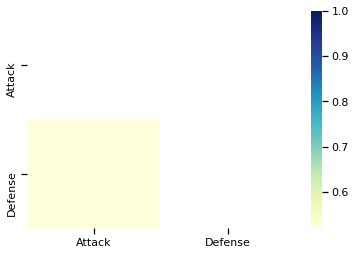

In [76]:
corrmat = data.corr(method='spearman')
f, ax = plt.subplots(figsize=(6, 4))

matrix = np.triu(corrmat)
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1, mask=matrix, annot = False)

Dengan menggunakan Pearson Correlation, dapat disimpulkan bahwa 'Attack' dan 'Defense' cukup memiliki korelasi yang dapat mempengaruhi satu sama lain, dibuktikan dengan corr=0.55

2. Pairplot untuk mengetahui visualisasi dari korelasi data kedua features

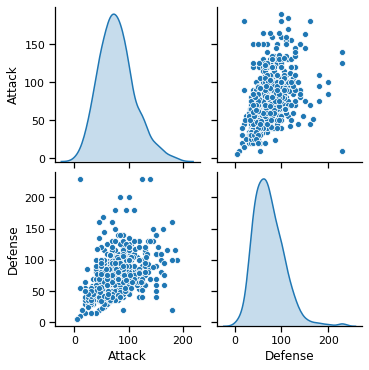

In [49]:
sns.set_context('notebook')

sns.pairplot(data, diag_kind='kde');


Visualisasi tersebut semakin menegaskan bahwa hubungan kedua fitur adalah positif.

3. Distribusi Features 'Attack' dan 'Defense'

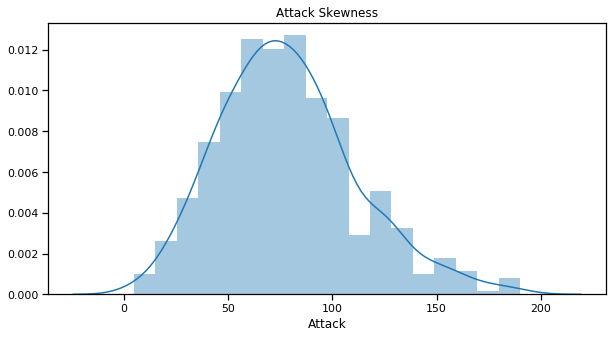

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.distplot(data['Attack'])
plt.title('Attack Skewness')
plt.show()

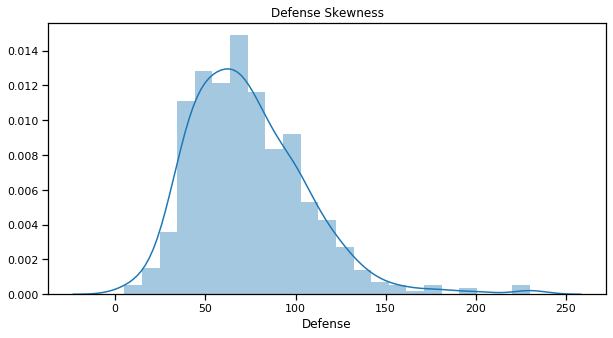

In [51]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.distplot(data['Defense'])
plt.title('Defense Skewness')
plt.show()

In [52]:
data.skew()

Attack     0.56361
Defense    1.14988
dtype: float64

Hal ini dapat diartikan bahwa atribut 'Defense' memiliki kemiringan kanan (right skewed), berbeda dengan atribut 'Attack' yang terdistribusi normal atau Gaussian.

## Data Preprocessing dengan Transformasi Logaritmik

In [84]:
columns = ['Attack','Defense']
data[columns] = np.log1p(data[columns])

In [85]:
data

,Attack,Defense
0,1.591686,1.591686
1,1.637663,1.640720
2,1.689882,1.692090
3,1.725463,1.761349
4,1.603479,1.565317
...,...,...
593,1.631370,1.673489
594,1.673489,1.716380
595,1.640720,1.574565
596,1.712589,1.614495


In [86]:
data['Attack'] = pd.to_numeric(data["Attack"])
data["Defense"] = pd.to_numeric(data["Defense"])

In [87]:
log_data = data.iloc[:, 0:2]
log_array = np.array(log_data)
print (log_array)

[[1.59168587 1.59168587]
 [1.63766276 1.6407201 ]
 [1.68988188 1.69208955]
 ...
 [1.6407201  1.57456514]
 [1.71258905 1.61449544]
 [1.76134864 1.64666717]]


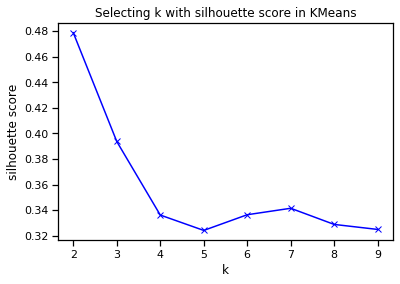

In [88]:
# MENENTUKAN JUMLAH CLUSTER (K) Menggunakan Silhouette Score

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

meanDistortions=[]

for k in range(2, 10):
    kmeans_model=KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(data)
    prediction=kmeans_model.labels_
    meanDistortions.append(silhouette_score(data, prediction))


plt.plot(range(2, 10), meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Selecting k with silhouette score in KMeans');

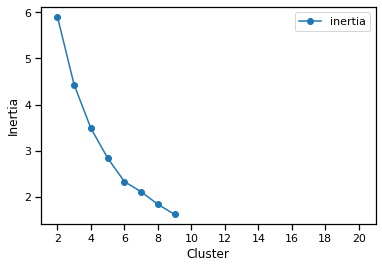

In [89]:
# Menentukan Jumlah Klaster menggunakan Elbow Method 
km_list = list()

for clust in range(2,10):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(data)
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(1,21)
ax.set(xlabel='Cluster', ylabel='Inertia');
### END SOLUTION

**Dengan menggunakan Metode Elbow hasil yang didapatkan tidak dapat diambil kesimpulan jumlah klaster terbaik, sehingga digunakan Metode Silhouette Score yang mana didapatkan k=2 adalah klaster optimum.**

In [90]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=2, random_state=200)
kmeans.fit(log_array)
data['kluster'] = kmeans.labels_
print(data.head())

     Attack   Defense  kluster
0  1.591686  1.591686        0
1  1.637663  1.640720        1
2  1.689882  1.692090        1
3  1.725463  1.761349        1
4  1.603479  1.565317        0


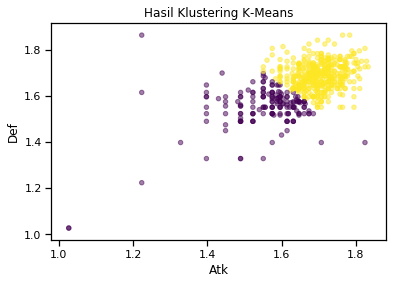

In [91]:
plt.scatter(data.Attack, data.Defense, s = 20, c = data.kluster, marker = "o", alpha = 0.5)
plt.title("Hasil Klustering K-Means")
plt.xlabel("Atk")
plt.ylabel("Def")
plt.show()